# Variational autoencoders

In this project, we will explore the idea of variational autoencoders. Also, we will implement a variational autoencoder using Tensorflow to generate images like MNIST hand-written digits.

## Table of Contents
- [1 - Introduction](#1)
- [2 - Autoencoders](#2)
    - [2.1 - Dimension Reduction using Autoencoders](#2.1)
- [3 - Variational autoencoders](#3)
    - [3.1 - Theory behind VAEs](#3.1)
        - [3.1.1 - Evidence Lower BOund](#3.1.1)
        - [3.1.2 - Variational Inference](#3.1.2)
        - [3.1.3 - Reparameterization Trick](#3.1.3)
        - [3.1.4 - The probability model perspective](#3.1.4)
        - [3.1.5 - The autoencoder perspective](#3.1.5)
        - [3.1.6 - Hand-written Image Generator](#3.1.6)

<a name='1'></a>
## Introduction
Variational autoencoders (VAEs) are a type of deep generative models that encode input data into a lower-dimensional space, randomly sample points from this latent space, and then decode these points to generate new data. More precisely, VAEs can be viewed in two different ways:

1. VAEs are a type of autoencoder with a key distinction from traditional autoencoders (AEs), which will be explained later when we discuss variational autoencoders.
2. VAEs are probabilistic generative models that operate on the joint distribution of observed and latent variables.

In this notebook, we will provide a brief overview of autoencoders, variational autoencoders, delve into the underlying mathematics, and demonstrate the implementation of both an autoencoder and a variational autoencoder with the MNIST dataset.

<a name='2'></a>
## Autoencoders
An autoencoder is a type of neural network used to reduce high-dimensional data to a lower-dimensional representation. It consists of three parts: encoder, bottleneck, and decoder. The encoder compresses the data to a lower-dimensional form, the bottleneck stores the crucial information, and the decoder reconstructs the output from the bottleneck. During training, the output is compared to the original input to calculate reconstruction loss, which is the squared error between the input and output. Essentially, training an autoencoder involves optimizing the encoder and decoder to minimize the reconstruction error.

Applications of autoencoders include:

- Dimensionality reduction
- Image denoising
- Anomaly detection

| <img src="https://miro.medium.com/v2/resize:fit:600/0*83pAHsVsnsqySOHN.png" width="400" height="300"> | 
|:--:| 
| *Autoencoder architecture* |
*source : [Medium](https://medium.com/@soumallya160/the-basic-concept-of-autoencoder-the-self-supervised-deep-learning-454e75d93a04)*

<a name='2.1'></a>
### Dimension Reduction using Autoencoders

<a name='3'></a>
## Variational autoencoders

A variational autoencoder (VAE) is a type of probabilistic autoencoder designed to model the distribution of data. They share a similar architecture with standard autoencoders, featuring an encoder, bottleneck, and decoder. However, the way information is processed in the bottleneck of a VAE differs from that of a traditional autoencoder.

VAEs can be understood in two main ways:

1. Probabilistic Generative Model: VAEs function as probabilistic generative models, employing a Bayesian approach to learn the probability distribution of input data.
2. Autoencoder: While VAEs belong to the family of autoencoders, they differ in that they are probabilistic rather than deterministic. In a VAE, the compressed representation (latent vector 𝑧) is not directly learned but is generated randomly based on the learned distribution.


| 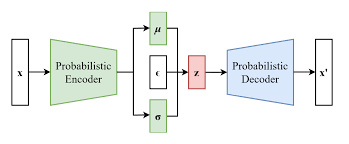 | 
|:--:| 
| *Variational autoencoder architecture* |
*source : [Medium](https://www.google.com/imgres?imgurl=https%3A%2F%2Fmiro.medium.com%2Fv2%2Fresize%3Afit%3A1358%2F0*2DZwupQZTnpBEH1s.png&tbnid=6LvLReF4DrHNNM&vet=12ahUKEwig6JCg5rKEAxX4BfsDHW-xCewQMygSegQIARB0..i&imgrefurl=https%3A%2F%2Fmedium.com%2Fmlearning-ai%2Fvariational-auto-encoders-vae-for-the-numerai-dataset-2709dcc7e449&docid=Zkc9F34LppKCyM&w=1264&h=524&q=variational%20auto%20encoder&ved=2ahUKEwig6JCg5rKEAxX4BfsDHW-xCewQMygSegQIARB0)*

<a name='3.1'></a>
### Theory behind VAEs

<a name='3.1.1'></a>
#### Evidence Lower BOund
The Evidence Lower Bound (ELBO) plays a crucial role in approximating the posterior distribution. It serves as a minimum value for the logarithm of the total likelihood of the data given the model parameters. By maximizing the ELBO, we effectively minimize the Kullback-Leibler (KL) divergence between the actual posterior distribution and the approximated one.

Before delving into the lower bound concept, let's lay out the problem. Let's assume we have two random variables: $X$ (observed or real data) and $Z$ (hidden or latent variable). Both $X$ and $Z$ follow a joint distribution denoted as $p(x,z;\theta)$, where $\theta$ represents the distribution's parameters.

Now, what exactly is the evidence? The evidence simply refers to the log-likelihood of observations 𝑥 under a fixed $\theta$. Essentially, the likelihood function indicates how well our model and parameter $\theta$ match the observations. A high likelihood value suggests that the model fits the data well. Our objective now is to find a lower bound for $p(x;\theta)$. Let's assume that $z$ follows a distribution denoted as 𝑞. We can leverage a technique called marginalization to derive the desired lower bound.

$$\begin{align} log p(x;\theta) &= log\int_{z} p(x,z;\theta) dz \\ &= log\int_{z} p(x,z;\theta) \frac{q(z)}{q(z)} dz \\ &= log E_{z\sim q}[\frac{p(x,Z;\theta)}{q(Z)}] \\ & \geq^* E_{z\sim q}[log \frac{p(x,Z;\theta)}{q(Z)}]\end{align}$$

$$\begin{align} => ELBO = E_{z\sim q}[log \frac{p(x,Z;\theta)}{q(Z)}] \ (1) \end{align}$$

\* : This inequality is the result of [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality). Since $log$ is a concave function, $log(E[X]) \geq E[log(X)]$ where X in this statement is $\frac{p(x,Z;\theta)}{q(Z)}$.

Now, let's explain why maximizing the Evidence Lower Bound (ELBO) leads to minimizing the Kullback-Leibler (KL) divergence between the true posterior distribution and the approximating distribution. Let's assume we aim to identify a distribution, denoted as $q$, that accurately approximates $p(z|x; \theta)$. In the context of Variational Autoencoders (VAEs), our goal is to approximate $p(z|x; \theta)$. This requires us to find a distribution that closely approximates it, which is why I am discussing this specific distribution.

$$\begin{align} KL \ (q(z) \ || \ p(z|x;\theta)) &= E_{Z \sim q}[log \frac{q(Z)}{p(Z|x;\theta)}] \\ &= E_{Z \sim q}[log \ q(Z)] - E_{Z \sim q}[log \ p(Z|x;\theta)] \\ &= E_{Z \sim q}[log \ q(Z)] - E_{Z \sim q}[log \frac {p(Z,x;\theta)}{p(x;\theta)}] \\ &= E_{Z \sim q}[log \ q(Z)] - E_{Z \sim q}[log \ p(Z,x;\theta)] + E_{Z \sim q}[log \ p(x;\theta)] \\ &= E_{Z \sim q}[log \ p(x;\theta)] - E_{Z \sim q}[log\frac{p(x,Z;\theta)}{q(Z)}] \\ &=^{*,(1)} log \ p(x;\theta) - ELBO \\ &= evidence - ELBO\end{align}$$

\* : Notice that  $log p(x;\theta)$ is not dependent on  $z$, so it behaves like a constant and can be taken out of the expectation.

Now, consider that when $\theta$ is fixed and we are searching for a distribution q that minimizes the Kullback-Leibler (KL) divergence, the evidence term acts as a constant. Therefore, due to the negative sign of the Evidence Lower Bound (ELBO), maximizing the ELBO results in minimizing the KL divergence.

<a name='3.1.2'></a>
#### Variational Inference

In many real-world situations, it's impractical to calculate the exact probability distribution due to either complex models or large datasets. Variational inference offers a method to estimate this distribution by selecting a simpler distribution from a set of parameterized distributions. The concept of variational inference involves treating the task of approximating the probability distribution as an optimization challenge. The objective is to identify the distribution within the chosen set that minimizes the difference, measured by Kullback-Leibler divergence, from the true distribution.

By maximizing the Evidence Lower Bound (ELBO), a surrogate for the log likelihood of the data based on the model parameters, variational inference aims to find the most precise approximation to the actual probability distribution given the model and observed data.

When dealing with models containing hidden ($Z$) and observed ($X$) variables and trying to determine the likelihood of $Z$ given $X$, variational inference aids in finding a suitable estimation. However, let's first understand why we cannot directly calculate  $p(z|x)$ . By applying Bayes' theorem,  $p(z|x)$  can be expressed as follows:

$$\begin{align} p(z|x) = \frac{p(z,x)}{p(x)} = \frac{p(x|z) \times p(z)}{\int_z p(z,x) dz} \end{align}$$

The key thing to note is that computing the denominator is not always possible. Therefore, variational inference is utilized.

In this method, we select a group of distributions called the variational distribution family and strive to discover a $q$ that comes closest to  $p(z|x)$ within this family. Let's also assume that $\phi$ controls these distributions (it's the variational parameter). Hence, our aim is to identify a $\phi$ that minimizes the KL divergence between  $q_{\phi}(z)$ and  $p(z|x)$ . Interestingly, as indicated by the [Evidence Lower BOund](#3.1.1), instead of minimizing the KL divergence, we can maximize the ELBO to find the most accurate approximation. Therefore, we must now handle $\phi$ as it is a parameter that characterizes the family of distributions.

$$\begin{align} ELBO(\phi) &= L(\phi) = E_{Z \sim q_{\phi}}[log \ p(x,Z) - log \ q(Z)] \\ \hat{\phi} &= argmax_{\phi} \ L(\phi) \end{align}$$

<a name='3.1.3'></a>
#### Reparameterization Trick

In a typical variational inference scenario, our goal is to estimate the distribution of hidden variables using a variational distribution. When the variational distribution involves sampling from a distribution like a Gaussian, it introduces randomness into the calculation of gradients during the optimization procedure. The reparameterization trick helps to tackle this problem by modifying the way the random variable is represented so that the randomness is isolated from the distribution's parameters. This allows gradient-based optimization methods to navigate through the random sampling process, resulting in more consistent training with lower variance gradient estimations. Therefore, this approach enables us to conduct stochastic gradient ascent on the ELBO. Now that we understand how we approximate the hidden variable distribution, we will employ optimization techniques to determine the optimal parameters in our scenario.

##### **High Variance Gradients**
First lets explore what happens if we do not use reparameterization trick. Let’s say we want to take the gradient w.r.t. $\theta$ of the $E_{x \sim p}[f_{\theta}(x)]$. If the p distribution is not parameterized by $\theta$, then the gradient can easily go inside of the expectation. However, if it is not the case, then we can not calculate the gradient in general.

First, let's consider what happens if we don't employ the reparameterization trick. For instance, suppose we aim to compute the gradient with respect to the parameter $\theta$ of the expectation $E_{x \sim p}[f_{\theta}(x)]$. If the distribution $p$ is not determined by $$, then the gradient can straightforwardly be incorporated within the expectation. Nevertheless, if this is not the scenario, then in general, we are unable to compute the gradient.

$$\begin{align} \nabla_{\theta} \ E_{x \sim p_{\theta}}[f_{\theta}(x)] &= \nabla_{\theta} \int_{x} p_{\theta}(x) f_{\theta}(x) dx \\ &= \int_{x}\nabla_{\theta} ( p_{\theta}(x) f_{\theta}(x)) dx \\ &= \int_{x}\nabla_{\theta}p_{\theta}(x) f_{\theta}(x)dx + \int_{x} p_{\theta}(x) \nabla_{\theta} f_{\theta}(x) dx \\ &= \int_{x}\nabla_{\theta}p_{\theta}(x) f_{\theta}(x)dx + E_{x \sim p_{\theta}}[\nabla_{\theta}f_{\theta}(x)]\end{align} $$

The first term in the final expression is not guaranteed to be an expectation. While Monte Carlo methods necessitate the ability to sample from $p(x)$, they do not inherently require access to its gradient information. This limitation becomes challenging when dealing with scenarios where computing the gradient of $p(x)$ with respect to $\theta$ analytically is infeasible, which is often the case in practice. Therefore, in order to use Monte Carlo methods, we need to apply changes that remove $\nabla_{\theta} \ p_{\theta}(x)$ from our integrals.

##### **Reparameterization Trick Explanation**
Sometimes the random variable $x \sim p_{\theta}(x)$ can be reparameterized as a deterministic function $g$ of $\theta$ and of a random variable $\epsilon \sim D$, where $D$ is not parameterized on $\theta$.
$$\begin{align} \epsilon &\sim D \\ x &= g_{\theta}(\epsilon) \end{align}$$

Now lets see what happen if we take gradient from $E_{x \sim p}[f_{\theta}(x)]$:

$$\begin{align} \nabla_{\theta} \ E_{x \sim p_{\theta}}[f_{\theta}(x)] &= \nabla_{\theta} \ E_{\epsilon \sim g_{\theta}}[f(g_{\theta}(\epsilon))] \\ &=^* E_{\epsilon \sim g_{\theta}}[\nabla_{\theta} f(g_{\theta}(\epsilon))]\end{align} $$

\* : Notice that $p(\epsilon)$ or more generally $D$ are not dependent to $\theta$, so we can move the gradient inside the expectation.

As we showed, now we can use Monte Carlo method to estimate this expectation.

One may ask that how how the $D$ distribution can be found? Generally it is not a simple problem, but some family of distributions conduct to simple answers. For example, in our case we are dealing with Guassian distributions($q(z|x)$) so we can choose standard normal distribution and our $g$ function as: $g_{\theta}(\epsilon) = \mu + \sigma \epsilon$.

In order to use reparameterization trick we should consider these requirenments as well:
- $f_{\theta}(x)$ must be differentiable w.r.t x its input.
- $g_{\theta}(\epsilon)$ must exist and be differentiable w.r.t. $\theta$.

##### **Stochastic Gradient Ascent of the ELBO**
For this part we will apply following idea on our original problem which was discussed in [Evidence Lower BOund](#3.1.1) and [Variational Inference](#3.1.2), so all notations and symbols are with respect to these parts.

The goal of using variational inference is to find the closest $q$ to $p(z|x)$ using continuous optimization techniques like gradient ascent. Consequently, at each step, parameters are updated in this way:

$$\begin{align} \phi_{t+1} = \phi_t + \alpha \ \nabla_{\phi} \ L(\phi) \end{align}$$
Notic that we are trying to maximize the ELBO, so gradient ascent is used.

As we saw before, ELBO consists of an expectation, so the gradients face randomness in back propagation. In order to get rid of this randomness, we can use reparametrization trick. Before exploring this idea, we need to check another problem and it is how can gradients be calculated? As we can see, what makes our computation complex is dealing with integrals. Therefore, we use stochastic gradient descent that consider a distribution for gradients and at each step, sample a gradient from that distribution to update the $\phi$. Instead of computing the exact gradient of the ELBO with respect to $\phi$, we formulate a random variable $V(\phi)$ that holds $E[V(\phi)] = \nabla_{\phi} L(\phi)$.(it is just a formal way of expressing the SGD). 
$$\begin{align} v &\sim V(\phi) \\ \phi_{t+1} &= \phi_{t} + \alpha \ v \end{align}$$

First, we will reparameterize $q_{\phi}(z)$ in the following way:
$$\begin{align} \epsilon &\sim N(0,1) \\ z &\sim g_{\phi}(\epsilon) \end{align}$$

Where $g$ has the form that we talked in previous section.

Now we replace every $z$ in ELBO equation with $g_{\phi}$:
$$\begin{align} L(\phi) = E_{\epsilon \sim N(0,1)}[log \ p(x,g_{\phi}(\epsilon)) - log \ q_{\phi}(g_{\phi}(\epsilon))]\end{align}$$

As we showed previously, this reparameterization enables us to approximate the ELBO via Monte Carlo sampling. So we will sample L times from standard normal distribution, denote ith sample as $\epsilon_i$ and estimate the expectation as:
$$\hat{L(\phi)} = \frac{1}{L} \sum_{l=0}^{L}[log \ p(x,g_{\phi}(\epsilon_l)) - log \ q_{\phi}(g_{\phi}(\epsilon_l))]$$

Because of all requirenments are satisfied, we can take gradient from both sides:
$$\nabla_{\phi} \ \hat{L(\phi)} = \nabla_{\phi} \frac{1}{L} \sum_{l=0}^{L}[log \ p(x,g_{\phi}(\epsilon_l)) - log \ q_{\phi}(g_{\phi}(\epsilon_l))]$$
It is easy to show that $E[\nabla_{\phi} \ \hat{L(\phi)}] = \nabla_{\phi} \ L(\phi)$.(just needs to bring the $\nabla_{\phi}$ out of expectation and move the expectation inside the sigma). Therefore, $E[\nabla_{\phi} \ \hat{L(\phi)}]$ is what we were looking for.
$$V(\phi)= \nabla_{\phi} \ \hat{L(\phi)}$$
In simpler terms,  sampling $\epsilon_1,\dots,\epsilon_L$ from $N(0,1)$, computing an approximate ELBO, and finding the gradient to this approximation is basically like drawing random gradients from a distribution $V(\phi)$ where the average gradient matches the ELBO gradient. This is why it's important for $D$ to be easy to sample from when using the reparametrization trick: we rely on samples from $D$ to create samples for $V(\phi)$.

<a name='3.1.4'></a>
#### The probability model perspective
Now we have all neccessary tools to show full theory behind the VAEs. In this section we will talk about probabilistic aspect of VAEs. 

Variational autoencoders (VAEs) function as generative models by defining a joint distribution over samples and their associated latent variable, denoted as $p(x,z)$. To delve into this, let's define the key components:
- Latent Variable(Z) : In VAEs, a latent variable $z$ is crucial for representing complex data. The model relies on a simplified conditional distribution $p(x,z)$, where $x$ denotes observable data, and $z$ remains latent. This distribution is expressed as $p(x,z)=p(x∣z)p(z)$, reflecting the likelihood of observed data given the latent variable and the distribution of the latent variable itself. This approach empowers VAEs to capture intricate patterns and generate meaningful data representations.
- Observation Variable(X) : The variable $x$ in VAEs represents observed data, and its distribution is characterized by $p(x∣z)$, denoting the likelihood of observing $x$ given a latent variable $z$. This likelihood distribution guides the VAE framework in learning and generating meaningful representations of input data, with $z$ capturing hidden patterns and enabling diverse sample generation during training.

The generative process is as follows:

1.Sample a latent variable $z$ from a prior distribution, typically $N(0,I)$.

2.Map $z$ to parameters of another distribution to sample $x$ using $p(x∣z)$.

Notice that in VAEs, both distributions are considered as normal distributions. Right now we can calculate the $p(x,z)$ using $p(z)$ and $p(x|z)$ while assuming we have a good $\theta$ parameter for them, but as i explained, $Z$ is a latent or hidden variable, so we do not have any information about it in our dataset. Therefore, in Variational Autoencoders (VAEs), the primary objective is to approximate the posterior distribution $p(z∣x)$ rather than the latent variable's prior $p(z)$ or the likelihood $p(x∣z)$. The unobservable nature of the latent variable $z$ in the dataset prompts the interest in determining the posterior distribution for each example in the data, representing the model's response to observed data. By focusing on $p(z∣x)$, VAEs adapt the latent space to the specific characteristics of the observed data, incorporating information, handling variability, and optimizing for effective reconstruction. This data-dependent approach aligns with the generative process and improves representation learning, ensuring that the latent space captures meaningful patterns for enhanced generative capabilities. While finding the $p(z|x)$, we can find $p(x)$, So our goals in VAEs are:

1.For fixed $\theta$, compute $p_{\theta}(z_i|x_i)$ for each $x_i$.

2.Maximize likelihood estimation (MLE) of $\theta$.

But we can not calculate these two without approximation because in order to compute these two, we need to marginalize out the $z$ in $p(x,z)$ and this means that an integral over all latent space is required which is intracitble.(I mentioned the problem more percisely in [variational inference](#3.1.2)). So in order to find an approximation solutions to these problems, variational inference is used. First, like previous parts, assume that $\theta$ is fixed. To approximate $p_{\theta}(z_i|x_i)$, we can use [variational inference](#3.1.2) and 
[evidence lower bound](#3.1.1). VI performs approximating by choosing a family of distributions and then finds the closest distribution to $p_{\theta}(z_i|x_i)$. 

Before defining our variational family, lets call the function that calculate the mean and standard deviation of x, $h_{\phi}$.($\phi$ is the parameter of the h function.) Note that in variational autoencoders this h is a neural network.
$$\begin{align} \mu &= h_{\phi}^1(x) \\ \sigma^2 &= h_{\phi}^2(x) \end{align}$$

$$variational \ family = \{q_{\phi} | q_{\phi} \ \sim N(h_{\phi}^1(x), h_{\phi}^2(x))\}$$


In order to have an loss function to measure how much these two distributions are close to each other, we use Kullback–Leibler divergence between $q_{\phi}(z_i|x_i) \in variational \ family$(approximation distribution) and $p_{\theta}(z_i|x_i)$. Now we know that minimizing the KL divergence is equivalent to maximizing the ELBO.
$$\begin{align} L(\phi) &= E_{Z_1,\dots,Z_n \sim q_{\phi}}\sum_{i=1}^n[log \ p_{\theta}(x_i,z_i) - log \ q_{\phi}(z_i|x_i)] \\ &= \sum_{i=1}^nE_{Z_i \sim q_{\phi}}[log \ p_{\theta}(x_i,z_i) - log \ q_{\phi}(z_i|x_i)]\end{align}$$

So far we have assumed that $\theta$ is fixed and we did not optimize the ELBO w.r.t $\theta$. But $\theta$ is the parameter of the decoder function and we have to optimize decoder as well as encoder. Therefore, we can extend the definition of our loss function and consider ELBO as function of both $\phi$ and $\theta$. Now to goal is to find both $\phi$ and $\theta$ that maximize the ELBO. We can show that why it is true in the following way: we know $L(\theta, \phi) = evidence(\theta) - KL(q_{\phi}(z) \ || \ p_{\theta}(z|x))$ and ELBO is a lower bound for log likelihood, so if we maximize the ELBO with respect to both $\phi$ and $\theta$, then the evidence will increase as much as ELBO and we can conclude that KL divergence is decreasing or being the same. Another way to justify this is we can consider the process of gradient ascent separately for $\phi$ and $\theta$. Consider this two forms for ELBO:
$$\begin{align} L(\theta, \phi) &=  log \ p_{\theta}(x) - KL(q_{\phi}(z) \ || \ p_{\theta}(z|x)) \ (1) \\  L(\theta, \phi) &= E_{Z \sim q_{\phi}}[log \ p_{\theta}(x,z) - log \ q_{\phi}(z|x)] \ (2)\end{align}$$

Now every step of maximization of the ELBO can be considered as two separate step(at each step, the other parameter will be considered as constant):
- maximize (1) with respect to $\phi$. This leads to minimizing the KL divergence.
- maximize (2) with respect to $\theta$. This leads to maximizing the likelihood of our data.

Therefore, our objective is:
$$\hat{\phi}, \hat{\theta} = argmax_{\phi, \theta} \ L(\phi, \theta)$$

Now that we’ve set up the optimization problem, we need to solve it. Unfortunately, the expectation present in the ELBO makes this difficult and cause the same problem that we saw in [Reparameterization Trick](#3.1.3), so we will use reparameterization trick followed by Monte Carlo method to calculate the gradients for stochastic gradient ascent. Assume we have n data points and for each data point we will sample L times from $N(0,I)$ because in VAEs, $q_{\phi}$ is a normal distribution. (similar to what i explained in Reparameterization trick section).

$$\begin{align} \epsilon_{i,l} &\sim N(0,I) \\ g_{\phi}(x_i, \epsilon_{i,l}) &= h_{\phi}^1(x) + h_{\phi}^2(x) \ \epsilon_{i,l} = z_i\end{align}$$

Recall $h_{\phi}^1(x) = \mu$ and $h_{\phi}^2(x) = \sigma^2$. Using the trick and Monte Carlo method we can calculate following gradient(requirenments for differentiation are satisfied):

$$\nabla_{\phi, \theta} \hat{L(\phi, \theta)} = \frac{1}{n}\sum_{i=1}^n \frac{1}{L}\sum_{l=1}^L \nabla_{\phi, \theta} [log \ p_{\theta}(x_i,g_{\phi}(x_i, \epsilon_{i,l}) - log \ q_{\phi}(g_{\phi}(x_i, \epsilon_{i,l}) | x_i))]$$

We've finished defining a loss function and how to minimize(actually maximize) it to achieve a $\hat{\phi}$ and $\hat{\theta}$. But we still can take advantage from our model distribution and by this i mean we can rewrite the ELBO in another way that leads to reduce the variance of gradients. What is neccessary to pay attention is KL divergence has a analytical form when both distributions are normal(now one of the reason why we defined $p(z)$ and $p(x|z)$ as Gaussian becomes clear.). First lets write ELBO in terms of $p_{\theta}(z)$:
$$\begin{align} L(\phi, \theta) &= \sum_{i=1}^nE_{Z_i \sim q_{\phi}}[log \ p_{\theta}(x_i,z_i) - log \ q_{\phi}(z_i|x_i)] \\ &= \sum_{i=1}^n\int q_{\phi}(z_i|x_i)[log \ p_{\theta}(x_i,z_i) - log \ q_{\phi}(z_i|x_i)] dz_i \\ &= \sum_{i=1}^n\int q_{\phi}(z_i|x_i)[log \ (p_{\theta}(x_i|z_i)p_{\theta}(z_i)) - log \ q_{\phi}(z_i|x_i)] dz_i \\ &= \sum_{i=1}^n\int q_{\phi}(z_i|x_i)[log \ p_{\theta}(x_i|z_i) + log \ p_{\theta}(z_i) - log \ q_{\phi}(z_i|x_i)] dz_i \\ &=^* \sum_{i=1}^n E_{z_i \sim q_{\phi}}[log \ p_{\theta}(x_i|z_i)] + \sum_{i=1}^n\int q_{\phi}(z_i|x_i)[log \ p_{\theta}(z_i) - log \ q_{\phi}(z_i|x_i)] dz_i \\ &= \sum_{i=1}^n E_{z_i \sim q_{\phi}}[log \ p_{\theta}(x_i|z_i)] + \sum_{i=1}^n E_{z_i \sim q_{\phi}}[log \ \frac{p_{\theta}(z_i)}{ q_{\phi}(z_i|x_i)}] \\ &= \sum_{i=1}^n E_{z_i \sim q_{\phi}}[log \ p_{\theta}(x_i|z_i)] - KL(q_{\phi}(z_i|x_i) || p_{\theta}(z_i))\end{align}$$

The analytical form is:
$$KL(q_{\phi}(z_i|x_i) || p_{\theta}(z_i)) = -\frac{1}{2}\sum_{j=1}^J 1 + log(\sigma^2(x_i)_j) - (\mu(x_i)_j)^2 - \sigma^2(x_i)_j$$

Therefore, the final ELBO after using analytical form and reparameterization trick and also Monte Carlo trick for the first term is:
$$\hat{L(\phi, \theta)} = \frac{1}{n}\sum_{i=1}^n [\frac{1}{2} \sum_{j=1}^J (1 + log(h_{\phi}^{(2)}(x_i)_j) - (h_{\phi}^{(1)}(x_i)_j)^2 - h_{\phi}^{(2)}(x_i)_j) + \frac{1}{L}\sum_{l=1}^L[logp_{\theta}(x_i|g_{\phi}(x_i, \epsilon_{i,l}))] $$

<a name='3.1.5'></a>
#### The autoencoder perspective
The process of VAEs is so similar to autoencoders, the encoder network maps the input data to a lower-dimensional latent space, and the decoder network maps the latent code back to the original data space. However there is a key difference between them: in autoencoders, an input $x$ is encoded as a single point in latent space while in VAEs, an input $x$ is encoded as a distribution and $z$ is sampled from this distribution. Therefore, VAEs are probabilistic version of autoencoders. By introducing randomness in the latent space, VAEs allow for a diverse set of $z$ values to contribute to the generation of $x$. This stochasticity during the sampling process leads to a more expressive and flexible generative model.

There is also another key difference between these two: Regularization. In VAEs, aside from the architectural considerations, a crucial element involves the regularization applied to the latent code. Within a VAE, the latent code undergoes regularization through a Gaussian distribution featuring a fixed mean and variance. This regularization serves the purpose of preventing overfitting by promoting a smooth distribution for the latent code, discouraging it from simply memorizing the training data.

Furthermore, this regularization plays a pivotal role in enabling VAEs to generate novel data samples that smoothly interpolate between existing training data points. This characteristic enhances VAEs' capability to produce new data samples resembling the patterns seen in the training data. Additionally, the regularization in VAEs serves to prevent the decoder network from precisely reconstructing the input data. Instead, it compels the decoder network to acquire a more generalized representation of the data, thereby enhancing the VAE's efficacy in generating diverse data samples.

Lets check the idea mathematically, $h_{\phi}$ is the encoder function and $f_{\theta}$ is the decoder function:

$$J_{AE}(\phi, \theta) = \sum_{i=1}^n ||x_i - f_{\theta}(h_{\phi}(x_i))||_2^2$$
$$J_{VAE}(\phi, \theta) = -\sum_{i=1}^n E_{z_i \sim q_{\phi}}[log(p_{\theta}(x_i|z_i))] - KL(q_{\phi}(z_i|x_i) || p_{\theta}(z_i))$$

We assume $p_{\theta}(x_i,z_i)$ in VAEs is a normal distribution like $N(\mu_d,\sigma_dI)$. So we can write $logp_{\theta}(x_i|z_i)$ in a way that the squared error appears:
$$J_{VAE}(\phi, \theta) = -\sum_{i=1}^n E_{z_i \sim q_{\phi}}[\frac{-||x_i - f_{\theta}(h_{\phi}(x_i))||_2^2}{2\sigma_d^2} \ log(\frac{1}{\sqrt{2\pi\sigma_d^2}})] - KL(q_{\phi}(z_i|x_i) || p_{\theta}(z_i))$$

Therefore, both of AE and VAE are minimizing the squared loss error. The error is called reconstruction loss because it is trying to penaltilize the difference between original input and reconstructed input. But in VAE's cost function we can see KL divergence and that is what makes the difference. This term acts like a regularization term in a sense that the model can not generate latent variables from arbitarary distribution(in AE one extreme scenario is that the AE maps each data point in dataset to a number and then decode them in reverse direction). The regularization will encourage the learned latent variables to have similar distributions to the prior.

<a name='3.1.6'></a>
#### Hand-written Image Generator